# MF-DFA Code Test on Fractional Gaussian Noise

The FBM libray for Python allows for easy generation of FBM time series. We can use our MF-DFA code to analyze this signal and make sure that the MF-DFA code is reading the right values. 

First let's import all the necessary libraries and functions (including the MF-DFA functions):

* To run this code the following libraries are required: matplotlib, numpy, MFDFA, fbm

All of these can be installed using pip install package_name

In [1]:
from fbm import FBM
import matplotlib.pyplot as plt
import sys
from MFDFA import MFDFA
import numpy as np

First, we need to generate the noise. With the fbm package we can create a function that allows for the Hurst parameter for the noise to be set. It outputs a signal function, f(t) that is the noise generated for the input sample number, Hurst parameter, and time length. This is primarily what we will use to test the MF-DFA functions.

In [21]:
""" In this function we are taking in the following information, set by the user:
num_samples | this is the number of points returned in the generated time series.
hurst_par | this is the hurst parameter for the time series
time_length | this is the length of time that the time series spans


We return a series of """
def fbmGenerate(num_samples, hurst_par, time_length):
    f = FBM(n=num_samples, hurst=hurst_par, length=time_length, method='daviesharte')

    # Generate a fBm realization (fractional Brownian motion)
    fbm_sample = f.fbm()

    # Generate a fGn realization (fractional Gaussian noise)
    fgn_sample = f.fgn()

    # Get the times associated with the fBm
    t_values = f.times()

    #plot the noise signal:
    plt.plot(t_values[1:],fgn_sample)
    plt.xlabel('Time, t (s)')
    plt.ylabel('Noise Signal, f(t) (Dimensionless)')
    plt.show()

    return t_values, fgn_sample 


Now we need to load our necessary MF-DFA functions:

#### Fluctuation Function:

In [9]:
#Our first helper function will allow us to find the fluctuation function
#of our data, as described in the Gomes article.


#Here, "order" represents the order of the polynomial fitting,
# "qList" represents the list of powers of the fluctuation function, (q=2 for a monofractal case)
# "lag" represents the list of lags as a series of integers that represent side lengths
# bmag is the total magnitude of the magnetic field data

def flucFunc(bmag, lag, qList, order):
    # Here we use the MFDFA function to give us the fluctuation function ,
    # which we then take the log of:
    lag, dfaList = MFDFA(bmag, lag=lag, q=qList, order=order)
    
    #Obtain the log-log plot which has a slope of the log of the Hurst parameter:
    # This will plot the set of points for each lag s.
    plt.loglog(lag,dfaList,'o')
        
        #label=f'fOU: MFDFA {qList[i]}=2'
    plt.xlabel(r'lag $s$')
    plt.ylabel(r'$F_q(s)$')
    plt.show()
    
    return lag,dfaList

#### Hurst Parameter, h(q) Function

In [16]:
# We also need a list of the Hurst parameters for varying q values:
def hList(lag,dfaList):
    # Initialize an empty list to hold our Hurst parameters:
    hList=[]
    
    # For every q in out list of powers, we need to find the Hurst parameter:
    for dfa in dfaList:
        # From the slope we obtain: slope = H + 1, so H = slope - 1
        # We fit to a 1st degree polynomial for a linear fit
        H=np.polyfit(np.log(lag)[2:12],np.log(dfa[2:12]),1)[0]
        
        #print(np.polyfit(np.log(lag)[2:9],np.log(dfa[2:9]),1)[0])
        #print('Estimated H = '+'{:.3f}'.format(H))

        hList.append(H)
    

    return hList

### Run the main code:

Here is a code block that will run all functions to perform MF-DFA on a generated time series with 1024 sample points, a Hurst parameter of 0.7, and a time length of 1. It will display the value of the h(q) function for varying q (q=[-20,20], not including q=0). 

Note: we need to choose a set of lags that will segment the integrated signal. For this, I will choose the same set as the MMS1 notebook to see if it will provide valid answers.

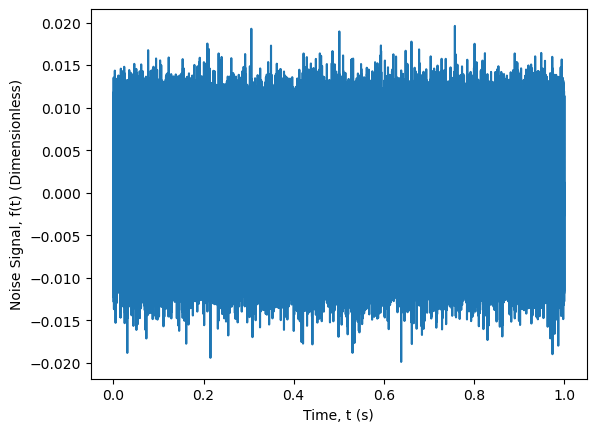

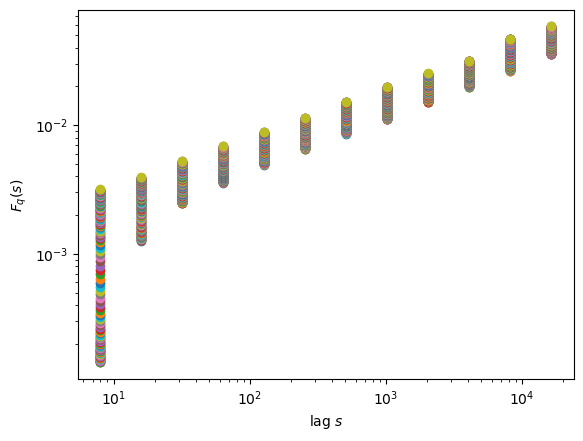

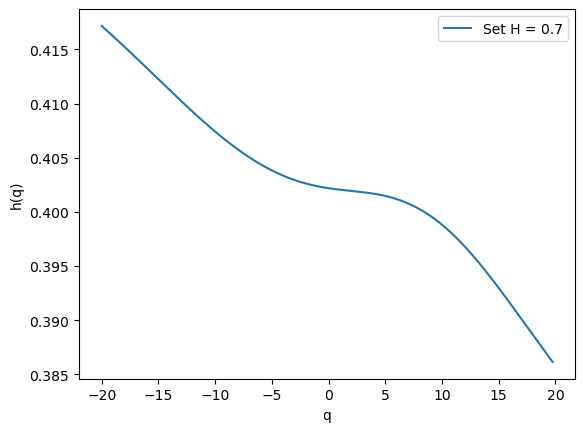

In [28]:

def main():
    
    ### SET THE HURST PARAMETER HERE ###
    
    #Let's try N=10^6 samples, 0.70 Hurst parameter, and 1s time length:
    hurstParam = 0.40
    timeLength = 1
    numSamples = 10**6

    #####################################

    # Generate the FGN : 
    timeSeries = fbmGenerate(numSamples, hurstParam, timeLength)

    # Extract the times and signal from the fbmGenerate function:
    times=timeSeries[0]
    signal=timeSeries[1]

    # Here we choose the set of lags:
    lag=np.power(2,range(15),dtype=int)

    # We also need to choose a range of q-values. -20 to 20 is what Gomes et al. use for MMS1 data.
    # -20 to 20 also provides a good amount of negative and positive points to get a sense of what 
    # is going on.
    qList=np.arange(-20,20,0.25).tolist()
    qList.remove(0)

    # In order to find the fluctuation function, we need to choose an order of polynomial fitting.
    # Gomes et al. choose order=3.
    order=3
    lag, dfaList=flucFunc(signal, lag, qList, order)
    #print(dfaList)

    # Here I am sending the dfaList and converting it to a list of Hurst parameters for each q.
    # I use the transpose of dfaList for the purpose of easily parsing each row of the matrix
    h_q=hList(lag,dfaList.T)

    # Plot h(q):
    plt.plot(qList,h_q)
    plt.xlabel('q')
    plt.ylabel('h(q)')
    plt.legend([f'Set H = {0.70}'])
    plt.show()

main()

## Conclusion:
The MF-DFA library seems to return roughly the correct Hurst parameter, depending on the q value scaling. This indicates that it should be returning the correct values with the MMS1 data.  